## Higgs Effective Field Theory (HEFT) Study: Training
> Created: Feb 12, 2024 Nicola de Filippis, Kurtis Johnson, Harrison B. Prosper<br>

### Introduction

In this notebook, we model the HEFT di-Higgs cross section[1] (per 15 GeV in the di-Higgs mass, $m_{hh}$) in which the 15 GeV bin size is mapped to a dimensionless value of 0.01. The HEFT parameter space is defined by the 5 parameters $\theta = c_{hhh}, c_{t}, c_{tt}, c_{ggh}, c_{gghh}$. In this proof-of-principle, we set $c_{hhh} = c_{t} = 1$, which reduces the parameter space to 3 dimensions and yields the expression,

\begin{align}
    \sigma(m_{gg}, \theta) & = \boldsymbol{c}^T(\theta) \cdot \boldsymbol{b}(m_{hh}), 
\end{align}

for the cross section per bin, $\sigma$, where

\begin{align}
    \boldsymbol{c}^T(\theta) & = (1, 
                 c_{tt}, 
             c_{ggh}, 
             c_{gghh}, \nonumber\\
             &\quad\,\,\,\, c_{tt} c_{ggh},
             c_{tt} c_{gghh}, 
             c_{ggh}c_{gghh}, \nonumber\\
             &\quad\,\,\,\, c_{tt} c_{ggh}^2, 
             c_{gghh} c_{ggh}^2, 
             c_{tt}^2, 
             c_{gghh}^2, 
             c_{ggh}^2, 
             c_{ggh}^3), 
\end{align}

is a row matrix of polynomials in the HEFT parameters
and $\boldsymbol{b}(m_{hh})$ is a column matrix of coefficients.

### Model

We attempt to model the 13 functions $b_i(m_{hh})$ using a *single* deep neural network with one input, $m_{hh}$, and 13 outputs, one for each function and a 1-parameter neural network. The training data for this notebook are prepared in the notebook `heft_prepare_traindata.ipynb`.

### References
  1. Lina Alasfar *et al.*, arXiv:2304.01968v1

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

# some simple dnn untilities
import dnnutil as dn

%matplotlib inline

device: cpu


In [2]:
# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

### Load training data

In [3]:
datafile = f'../data/heft_traindata.csv'

print('loading %s' % datafile)
df  = pd.read_csv(datafile)
print('number of rows: %d\n' % len(df))

df['target'] = df.sigma

print(f'min(sigma):  {df.target.min():10.3f} pb, '\
      f'avg(sigma):  {df.target.mean():10.3f} pb,  max(sigma): {df.target.max():10.3f} pb\n')

df[:5]

loading ../data/heft_traindata.csv
number of rows: 24000

min(sigma):       0.000 pb, avg(sigma):       0.114 pb,  max(sigma):      2.342 pb



,CTT,CGGH,CGGHH,mhh,sigma,target
0,-1.5,-0.4000,0.2666,0.015,0.077345,0.077345
1,0.5,1.0000,0.0000,0.385,0.002021,0.002021
2,0.0,0.5333,0.0666,0.565,0.000226,0.000226
3,-1.0,-0.4000,0.0000,0.445,0.010373,0.010373
4,-1.0,0.5333,0.3333,0.565,0.004299,0.004299


### Load spectra

In [4]:
spectra = pd.read_csv('../data/heft_spectra.csv')
len(spectra), spectra[:5]

(340,
    CTT    CGGH   CGGHH        17        18        19        20        21  \
 0 -3.0  0.8000  0.6000  0.024077  0.175103  0.238241  0.320428  0.391745   
 1 -3.0 -0.5333  0.0666  0.052271  0.410202  0.586312  0.636484  0.675402   
 2 -1.5 -0.5333  0.0666  0.016629  0.110292  0.163538  0.191439  0.212770   
 3 -3.0 -0.8000  1.0000  0.034356  0.251041  0.308580  0.359859  0.426314   
 4  0.5  0.5333  0.2666  0.005634  0.039345  0.042716  0.039986  0.036970   
 
          22        23  ...        87        88        89        90        91  \
 0  0.459120  0.570242  ...  0.019910  0.012445  0.014941  0.009954  0.012454   
 1  0.754226  0.884093  ...  0.004547  0.005024  0.013643  0.010234  0.011364   
 2  0.230752  0.277579  ...  0.003058  0.002040  0.003398  0.002038  0.002034   
 3  0.478569  0.572455  ...  0.031875  0.018003  0.014714  0.021289  0.018812   
 4  0.034295  0.029465  ...  0.000713  0.000709  0.000632  0.000826  0.000354   
 
          92        93        94        95

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

In [5]:
# Fraction of the data assigned as test data and validation
ntrain    = 20000                # training sample size
tfraction = (1-ntrain/len(df))/2 # test fraction
vfraction = tfraction            # validation fraction

# Split data into a part for training, validation, and testing
train_data, valid_data, test_data = dn.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5]

train set size:         20000
validation set size:     2000
test set size:           2000


,CTT,CGGH,CGGHH,mhh,sigma,target
0,-1.5,-0.5333,0.2666,0.515,0.014727,0.014727
1,0.5,0.1333,0.2666,0.525,0.002293,0.002293
2,-1.5,0.0000,0.3333,0.565,0.007817,0.007817
3,-1.0,0.1333,0.0000,0.225,0.066671,0.066671
4,-3.0,0.5333,0.3333,0.335,0.161414,0.161414


### Empirical risk (that is, average loss)

The empirical risk, which is the **objective function** we shall minimize, is defined by

\begin{align}
R_M(\omega) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\boldsymbol{x}_m, \omega)
\end{align*}
is the machine learning model with parameters $\omega$ to be determined by minimizing $R_M$. 
The quantity $x =  m_{hh}, c_{tt}, c_{ggh}, c_{gghh}$ are the inputs to the model and the target $t$ is the predicted cross section (per 15 GeV in $m_{hh}$).

(Aside: The empirical risk $R_M$ approximates the **risk functional**
\begin{align}
R[f] & = \int \cdots \int \, p(t, \boldsymbol{x}) \, L(t, f(\boldsymbol{x}, \omega)) \, dt \, d\boldsymbol{x} ,
\end{align}
where the quantity $p(t, \boldsymbol{x}) \, dt\, d\boldsymbol{x}$ is the probability distribution of the training data from which the sample $\{ (t_m, \boldsymbol{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn.) 

We shall fit the model $f$ for the cross section by minimizing the **weighted quadratic loss**

\begin{align}
    L(t, f) &= w (t - f)^2 ,
\end{align}
where $f$ is given by
\begin{align}
    \sigma(m_{hh}, \theta) & = \boldsymbol{c}^T(\theta) \cdot \boldsymbol{b}(m_{hh}),
\end{align}
and the weight is set to $w = 1 / t$. This is done so that each term in the empirical risk contributes roughly the same amount.  (This was inspired by Nicola's brilliant suggestion to use the errors in each histogram bin!)

The 13 functions $b_i(m_{hh})$ are approximated with a *single* neural network with $m_{hh}$ as input and the values of the functions $b_i(m_{hh})$ as outputs. If 1) the function $f$ has sufficient capacity (i.e., there exists a choice of parameters that yield an approximation arbitrarily close to the exact function $\sigma(m_{hh}, \theta)$), and 2) we have enough training data, and 3) the minimizer can find a good approximation to the minimum of the risk functional, then the calculus of variations shows that the minimum of the quadratic loss leads occurs when
\begin{align}
    f(\boldsymbol{x}, \omega^*) & = \int t \, p(t | \boldsymbol{x}) \, dt ,
\end{align}
where $\omega^*$ denotes the best-fit value of $\omega$, $p(t | \boldsymbol{x}) = p(t,  \boldsymbol{x}) / p(\boldsymbol{x})$, and $p(t, \boldsymbol{x})$ is the (typically, *unknown*) probability distribution of the training data.

### Define model for cross section
`heftnet` models the mapping $f : m_{hh}, c_{tt}, c_{ggh}, c_{gghh} \rightarrow \sigma$ using the known functional dependence of the cross section on $m_{hh}$, the Wilson coefficients, $\theta = c_{tt}, c_{ggh}, c_{gghh}$, and the observable-dependent functions $\boldsymbol{b}$. The mapping $g : m_{hh} \rightarrow \boldsymbol{b}$ is modeled with a function of the form
\begin{align}
    b_j(m_{hh}) & = P_j(m_{hh}) e^{-Q(m_{hh})},
\end{align}

where $P$ is a neural network with one input and 13 outputs and $Q = w m_{hh}$ is a single-parameter neural network where the parameter is denoted by $w$.

In [87]:
%%writefile heftnet.py
import torch
import torch.nn as nn
import numpy as np

name     = 'heftnet'
features = ['mhh', 'CTT', 'CGGH', 'CGGHH']
target   = 'target'
nodes    = 15
nhidden  =  4 
noutputs = 13

class HEFTNet(nn.Module):

    def __init__(self):

        # initial base class (nn.Module)
        super().__init__()

        # model the 13 functions b_i(m_hh) with a simple deep neural network 
        cmd = 'self.P = nn.Sequential(nn.Linear(1, nodes), nn.SiLU(),'
        for _ in range(nhidden):
            cmd += 'nn.Linear(nodes, nodes), nn.SiLU(),'
        cmd += 'nn.Linear(nodes, noutputs))'
        exec(cmd)

        # a single-parameter "neural network"!
        self.Q = nn.Linear(1, 1, bias=False)
        
    # required method: this function computes the sqrt(cross section)
    def forward(self, x):
        # x.shape: (N, 4), where N is the batch size

        # compute vector of Wilson coefficient functions
        mhh, ctt, cggh, cgghh = x.transpose(1, 0)

        C = [np.ones_like(ctt), 
             ctt, 
             cggh, 
             cgghh, 
             ctt*cggh,
             ctt*cgghh, 
             cggh*cgghh, 
             ctt*cggh**2, 
             cgghh*cggh**2, 
             ctt**2, 
             cgghh**2, 
             cggh**2, 
             cggh**3]

        C = torch.Tensor(np.array(C).T)

        # compute b coefficients with NN
        b = self.coeffs(mhh)
        
        # compute cross section(s) per 15 GeV bin
        xsec = C.mul(b) 
        xsec = xsec.sum(dim=1)

        return xsec
        
    def coeffs(self, x):
        # must reshape input from (N, ) to (N, 1)
        return self.P(x.view(-1, 1)) * torch.exp(-self.Q(x.view(-1, 1)))

Overwriting heftnet.py


In [88]:
import heftnet as NN
importlib.reload(NN)

name     = NN.name
model    = NN.HEFTNet()
features = NN.features
target   = NN.target

modelfile  = '%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d\n' % dn.number_of_parameters(model))

# check model
X = torch.Tensor(test_data[['mhh','CTT', 'CGGH', 'CGGHH']].to_numpy())
print('input.size:  ', X.size())

Y = model(X)
print('output.size: ', Y.size())

heftnet
HEFTNet(
  (P): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): SiLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): SiLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): SiLU()
    (6): Linear(in_features=15, out_features=15, bias=True)
    (7): SiLU()
    (8): Linear(in_features=15, out_features=15, bias=True)
    (9): SiLU()
    (10): Linear(in_features=15, out_features=13, bias=True)
  )
  (Q): Linear(in_features=1, out_features=1, bias=False)
)
number of parameters: 1199

input.size:   torch.Size([2000, 4])
output.size:  torch.Size([2000])


### Weighted quadratic loss

In [89]:
def average_quadratic_loss_weighted(f, t, x=None):
    # f and t must be of the same shape
    w = torch.where(t != 0, 1/torch.abs(t), 1)
    return  torch.mean(w * (f - t)**2)

### Train!

In [90]:
traces = ([], [], [])

traces_step   = 100
n_batch       = 150
n_epochs      = 8000
n_iterations  = n_epochs*(len(train_data) // n_batch)
early_stopping= 100000
learning_rate = 1.e-4

print(f'number of epochs:     {n_epochs:10d}')
print(f'number of iterations: {n_iterations:10d}')

number of epochs:           8000
number of iterations:    1064000


Iteration vs average loss
iteration train-set valid-set
0        0 241.2586212 70.1919556
100      100 126.9809036 47.7343788
200      200 96.5034790 40.1205444
300      300 81.9093094 35.4450951
400      400 70.1341171 31.5160999
845700600 0.0007625 0.0007469    845600:    745600/0.00074218/   1000000 0

stopping early!



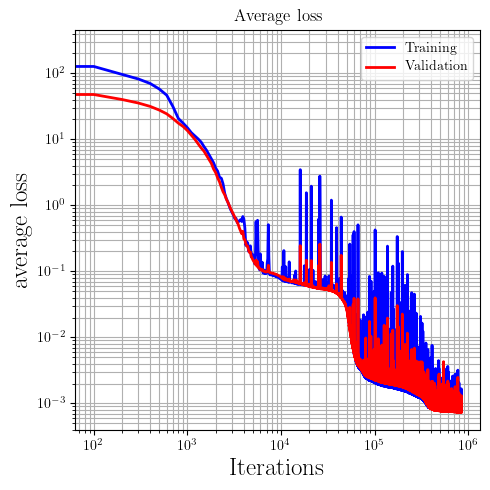

In [91]:
av_loss = average_quadratic_loss_weighted

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

traces = dn.train(model, optimizer, 
                  modelfile, early_stopping,
                  av_loss,
                  dn.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

dn.plot_average_loss(traces)

### Apply trained model to test data

In [92]:
import dnnutil as dn
importlib.reload(dn)

class AveragedHEFTNet(dn.AveragedModel):
    
    def __init__(self, model, scale=0.01, size=25):
        
        super().__init__(model, scale, size)
        
    def coeffs(self, x):
        self.eval()
        
        y = self.models[0].coeffs(x)
        for m in self.models[1:]:
            y += m.coeffs(x)
        y /= len(self.models)
        return y

device: cpu


In [93]:
Load_lowest_loss_model = True
Average_model = False

if Load_lowest_loss_model:
    print('load lowest loss model dictionary: %s' % modelfile)
    modeldict = torch.load(modelfile)
    model = NN.HEFTNet()
    model.load_state_dict(modeldict)

if Average_model:
    print('create averaged model')
    model = AveragedHEFTNet(model, scale=0.0001, size=100)
    
# NN-approximated cross sections 
model.eval()
y = model(X).detach().numpy()

# POWHEG-predicted cross sections
t = test_data['target'].to_numpy()

load lowest loss model dictionary: heftnet.dict


### Plot NN prediction vs. predicted cross section

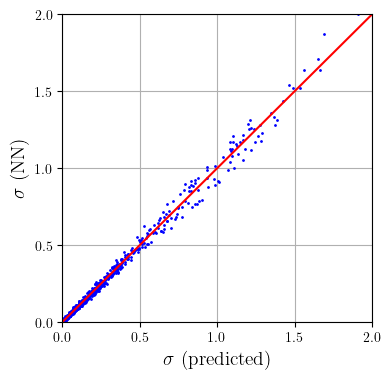

In [94]:
def plot_results(y, t, 
                 xmin=0.0, xmax=2.0, 
                 ymin=0.0, ymax=2.0, 
                 ftsize=14, 
                 filename='figures/fig_results.pdf'):

    # create an empty figure
    fig = plt.figure(figsize=(4, 4))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    
    ticks = np.linspace(xmin, xmax, 5)
    
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(ticks)
    ax.set_xlabel(r'$\sigma$ (predicted)', fontsize=ftsize)

    ax.set_ylim(ymin, ymax)
    ax.set_yticks(ticks)
    ax.set_ylabel(r'$\sigma$ (NN)', fontsize=ftsize)
    
    ax.plot(y, t, 'b', marker='.', markersize=2, linestyle='')
    ax.plot([xmin, xmax], [ymin, ymax], linestyle='solid', color='red')

    ax.grid(True, which="both", linestyle='-')

    plt.savefig(filename)
    plt.show()

plot_results(y, t)

### Plot coefficients

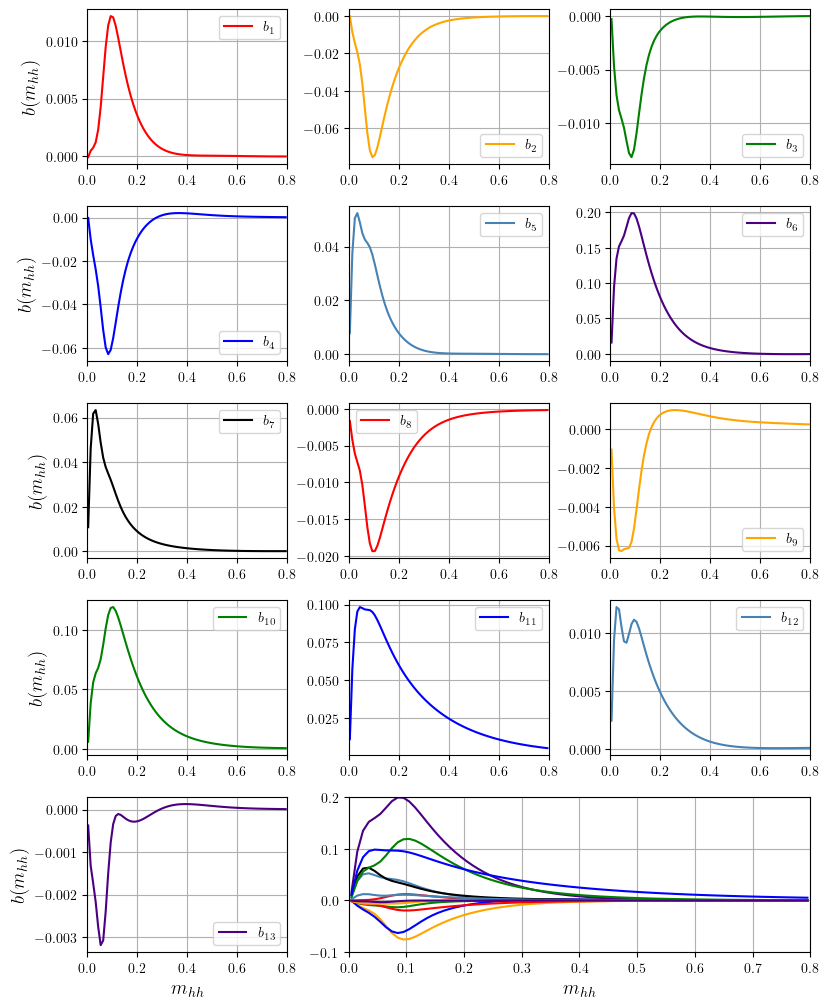

In [98]:
def plot_coeffs(dnn, ftsize=14):
    
    # define equally spaced points for m_hh
    xbins= 80
    xmin = 0
    xmax = xbins/100
    x = np.linspace(xmin, xmax, xbins+1)
    x = (x[1:]+x[:-1])/2

    # detach from computation tree and return coefficients as a numpy array
    b = dnn.coeffs( torch.Tensor(x) ).detach().numpy()
    nplots = len(b[0])
    
    # create a mosaic of plots
    # a b c
    # d e f
    # : : :
    # o p p
    # last plot occupies two slots
    fig, axes = plt.subplot_mosaic('abc;def;ijk;lmn;opp', 
                                   figsize=(8, 10))
    # need the following to make layout look reasonable
    fig.tight_layout()

    # get subplot keys a, b, c, etc.
    keys = list(axes.keys())
    keys.sort()

    kolor = ['red', 'orange', 'green', 'blue', 'steelblue', 'indigo', 'black']

    nrows = 5
    ncols = 3
    
    for i, key in enumerate(keys[:-1]):
        
        ax = axes[key]

        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)
            
        if i % ncols == 0:
            ax.set_ylabel(r'$b(m_{hh})$', fontsize=ftsize)

        # plot (i+1)th coefficient
        y = b.T[i]
        c = kolor[i % len(kolor)]
        index = i + 1
        ax.plot(x, y, color=c, label='$b_{%d}$' % index)
        ax.legend()
        ax.grid()

    # last plot: superimpose all coefficient plots
    ax = axes['p']
    
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

    ymin = -0.10
    ymax =  0.20
    ax.set_ylim(ymin, ymax)
    
    for i in range(nplots):
        # plot (i+1)th coefficient
        y = b.T[i]
        c = kolor[i % len(kolor)]
        index = i + 1
        ax.plot(x, y, color=c)
    ax.grid()

    plt.savefig('figures/fig_coefficients.pdf')

plot_coeffs(model)

### Plot spectra

 1. Compute spectra approximated with the NN model.
 2. Compare with POWHEG spectra that have not been used in the training.

In [99]:
def get_spectra(model, df, row):

    # get column names
    columns= list(df.columns)
    params = columns[:3]
    bins   = columns[3:]
    
    xbins = len(bins)
    xmin  = 0
    xmax  = xbins/100
    
    # define mhh values
    x = np.linspace(xmin, xmax, xbins+1)
    x = (x[1:]+x[:-1])/2

    # get parameter names
    ctt, cggh, cgghh = df[params].iloc[row]

    # create input data
    inputs = []
    for mhh in x:
        inputs.append([mhh, ctt, cggh, cgghh])

    # get predicted cross section
    spectrum = df[bins].iloc[row].to_numpy() # predicted spectrum  

    # get approximated cross section
    inputs = torch.Tensor(np.array(inputs))
    
    model.eval()   
    y = model(inputs).detach().numpy()       # approximated spectrum 

    return spectrum.sum(), x, y, spectrum, ctt, cggh, cgghh

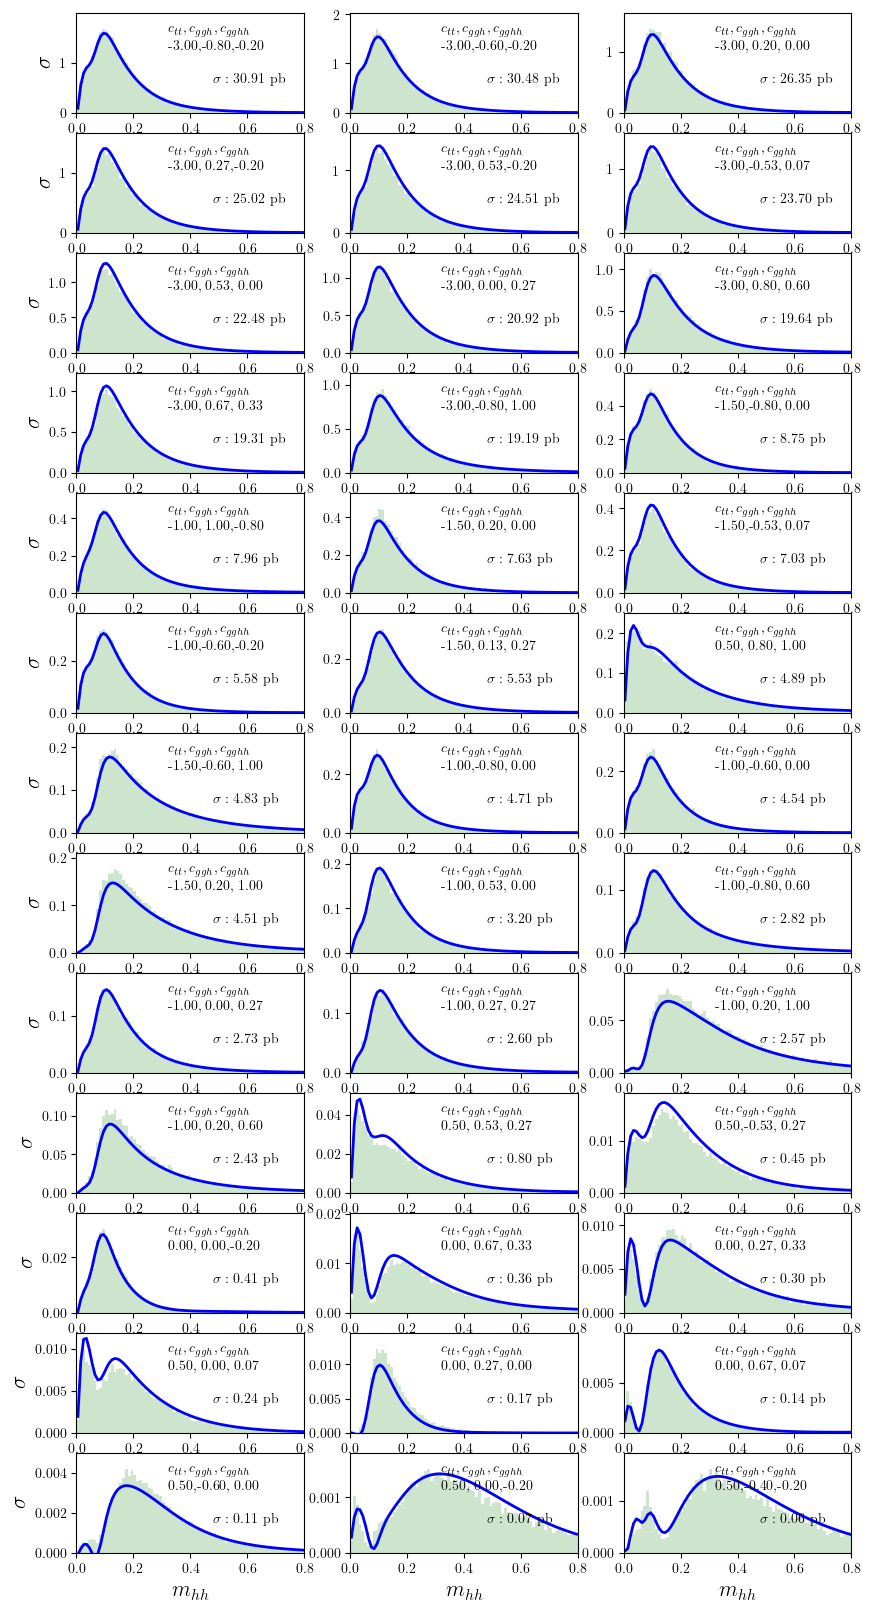

In [100]:
def plot_spectra(data, 
                 ftsize=16, 
                 filename='fig_spectra_comparisons.pdf'):

    plt.rcParams.update({'font.size': 10})
    
    _, x, y, s, _,_,_ = data[0]
    xbins = len(x)
    xmin, ymin  = 0, 0
    xmax = xbins/100

    # create an empty figure
    fig = plt.figure(figsize=(10, 20))
    fig.tight_layout()

    # work out number of columns and number of plots
    ncols = 3
    nrows = len(data) // ncols
    ndata = nrows * ncols

    # loop over coefficients

    for i, (total_xsec, x, y, f, ctt, cggh, cgghh) in enumerate(data):

        index = i+1
        ax  = fig.add_subplot(nrows, ncols, index)

        # setup x-axis
        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$m_{hh}$', fontsize=ftsize)

        # setup y-axis
        ymax = 1.2 * f.max()
        ax.set_ylim(ymin, ymax)
        
        if i % ncols == 0:
            ax.set_ylabel(r'$\sigma$', fontsize=ftsize)

        # annotate plot
        xpos = xmin + 0.40 * (xmax-xmin)
        ypos = ymin + 0.80 * (ymax-ymin)
        ystep= (ymax-ymin)/6
        ax.text(xpos, ypos, r'$c_{tt},c_{ggh},c_{gghh}$'); ypos -= ystep
        ax.text(xpos, ypos, '%5.2f,%5.2f,%5.2f' % (ctt, cggh, cgghh)); ypos -= ystep
        
        xpos = xmin + 0.60 * (xmax-xmin)
        ypos -= ystep
        ax.text(xpos, ypos, r'$\sigma:$ %5.2f pb' % total_xsec)
        
        # predicted spectra
        ax.hist(x, bins=xbins, range=(xmin, xmax), weights=f, 
                    color='green', alpha=0.2)

        # NN-approximated spectra
        ax.plot(x, y, color='blue', linewidth=2)

    plt.savefig(filename)
    plt.show()

# ------------------------------------------------------------------
M = 39
data = []
for row in range(M):
    data.append( get_spectra(model, spectra, row) )

# sort in decreasing cross section
data.sort()
data.reverse()

plot_spectra(data)